In [1]:
import pandas as pd
import numpy as np
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
import joblib

In [2]:
# Step 1: Load and Prepare the Dataset
iris = load_iris()
data = pd.DataFrame(data=iris.data, columns=iris.feature_names)
data['target'] = iris.target

In [3]:
# Check for missing values
print(f"Missing values: \n{data.isnull().sum()}")

Missing values: 
sepal length (cm)    0
sepal width (cm)     0
petal length (cm)    0
petal width (cm)     0
target               0
dtype: int64


In [4]:
# Feature and Label Splitting
X = data[iris.feature_names]
y = data['target']

In [5]:
# Normalizing Features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [6]:
# Split Data into Training and Testing Sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42, stratify=y)

In [7]:
# Step 2: Model Training and Evaluation with Cross-Validation
model = LogisticRegression(random_state=42, max_iter=200)

In [8]:
# Cross-validation
cv_scores = cross_val_score(model, X_train, y_train, cv=5)
print(f"Cross-validation scores: {cv_scores}")
print(f"Mean cross-validation score: {cv_scores.mean():.2f}")


Cross-validation scores: [0.95238095 0.95238095 1.         1.         1.        ]
Mean cross-validation score: 0.98


In [9]:
# Hyperparameter Tuning with GridSearchCV
param_grid = {
    'C': [0.1, 1, 10],
    'penalty': ['l2'],
    'solver': ['lbfgs', 'saga']
}

In [11]:
print(f"Training Accuracy: {train_accuracy:.2f}")
print(f"Testing Accuracy: {test_accuracy:.2f}")

Training Accuracy: 0.98
Testing Accuracy: 0.91


In [12]:

# Confusion Matrix
cm = confusion_matrix(y_test, test_predictions)


In [13]:
# Classification Report
report = classification_report(y_test, test_predictions, target_names=iris.target_names)
print(report)

              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        15
  versicolor       0.82      0.93      0.88        15
   virginica       0.92      0.80      0.86        15

    accuracy                           0.91        45
   macro avg       0.92      0.91      0.91        45
weighted avg       0.92      0.91      0.91        45



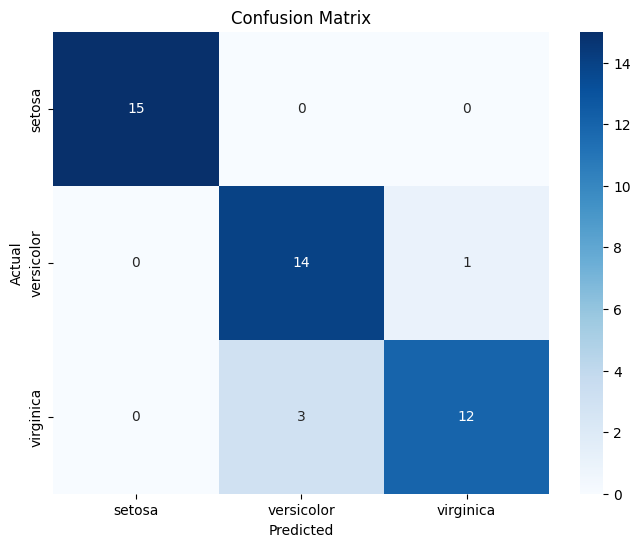

In [14]:
# Visualization of Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=iris.target_names, yticklabels=iris.target_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


In [15]:
# Step 3: Interactive Prediction
from IPython.display import display


In [16]:
# Function for interactive predictions
def make_prediction(input_features):
    scaled_features = scaler.transform([input_features])
    prediction = model.predict(scaled_features)[0]
    prediction_proba = model.predict_proba(scaled_features)[0]
    print("Predicted Class:", iris.target_names[prediction])
    print("Prediction Probabilities:")
    display(pd.DataFrame([prediction_proba], columns=iris.target_names))

In [17]:
# Example Input for Interactive Prediction
example_input = [5.1, 3.5, 1.4, 0.2]  # Example values for Sepal Length, Sepal Width, Petal Length, Petal Width
make_prediction(example_input)

Predicted Class: setosa
Prediction Probabilities:


C:\Users\vr320\AppData\Roaming\Python\Python313\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


,setosa,versicolor,virginica
0,0.979505,0.020494,6.764171e-07


In [21]:
import joblib


In [22]:
# Save the model
joblib.dump(model, 'iris_model.pkl')

# Save the scaler
joblib.dump(scaler, 'iris_scaler.pkl')

['iris_scaler.pkl']